## Super Resoultion - Deep Learning - Magnetic Data

In [1]:

import xarray as xr
import rasterio
import rioxarray

from scipy import ndimage
from skimage import color
from rasterio import enums

from scipy.ndimage import binary_dilation, binary_erosion, binary_fill_holes, generate_binary_structure

from scipy.ndimage import generic_filter
import rioxarray
from rioxarray.exceptions import NoDataInBounds

import numpy as np
import matplotlib.pyplot as plt

hello

In [2]:
orignal_state = 'WY_statemag_OFR00-0198.tif/WY_statemag_OFR00-0198.tif'
new_survey = 'WY_statemag_OFR00-0198.tif/TotalMag_AirborneMagneticSurveyMedicineBowWY2023.tif'

In [3]:
def mask_raster_area(raster, x_min, x_max, y_min, y_max):
    """
    Convert a specific area of the raster to NaN values.
    
    Args:
    raster (xarray.DataArray): The raster to modify
    x_min (float): Minimum x-coordinate of the area to mask
    x_max (float): Maximum x-coordinate of the area to mask
    y_min (float): Minimum y-coordinate of the area to mask
    y_max (float): Maximum y-coordinate of the area to mask
    
    Returns:
    xarray.DataArray: The modified raster with the specified area masked to NaN
    """
    # Create a boolean mask for the specified area
    mask = (raster.x >= x_min) & (raster.x <= x_max) & (raster.y >= y_min) & (raster.y <= y_max)
    
    # Apply the mask to the raster, setting the specified area to NaN
    masked_raster = raster.where(~mask, np.nan)
    
    print(f"Area masked to NaN: x={x_min}-{x_max}, y={y_min}-{y_max}")
    
    return masked_raster

def print_raster_info(raster, title):
    """
    Print information about a raster dataset.
    
    Args:
    raster (xarray.DataArray): The raster to get information from
    title (str): A title for the raster information
    """
    print(f"\n{title}")
    print(f"Shape: {raster.shape}")
    print(f"Coordinates: {raster.coords}")
    print(f"CRS: {raster.rio.crs}")
    print(f"Resolution: {raster.rio.resolution()}")
    print(f"Bounds: {raster.rio.bounds()}")
    print(f"Data type: {raster.dtype}")
    print(f"Nodata value: {raster.rio.nodata}")




In [4]:
def rgb_to_grayscale(raster_rgb):
    """
    Convert an RGB xarray DataArray to grayscale and return a Dataset
    containing both the original RGB and the new grayscale DataArray.
    The function preserves the input range (0-1 or 0-255) in the output
    and maintains the CRS from the input data.

    Parameters:
    raster_rgb (xarray.DataArray): Input RGB raster data (either 0-1 or 0-255 range)

    Returns:
    xarray.Dataset: Dataset containing original RGB and new grayscale DataArrays

    Raises:
    ValueError: If the input data does not have a CRS defined
    """
    # Check if CRS exists in the input data

    print(f"Input CRS: {raster_rgb.rio.crs}")
    print(f"Input shape: {raster_rgb.shape}")
    print(f"Input data type: {raster_rgb.dtype}")
    print(f"Input min value: {np.nanmin(raster_rgb.values)}")
    print(f"Input max value: {np.nanmax(raster_rgb.values)}")

    # 1. Determine if input is 0-1 or 0-255 range
    is_0_255 = np.nanmax(raster_rgb.values) > 1.0
    print(f"Input range is 0-255: {is_0_255}")

    # 2. Convert RGB to grayscale using scikit-image
    rgb_array = np.moveaxis(raster_rgb.values, 0, -1)
    print(f"RGB array shape after axis move: {rgb_array.shape}")
    
    if is_0_255:
        # If input is 0-255, convert to 0-1 for rgb2gray
        rgb_array = rgb_array / 255.0
        print("Scaled input to 0-1 range for rgb2gray")
    
    grayscale_data = color.rgb2gray(rgb_array)
    
    # Assert and print to check grayscale_data range
    print(f"Grayscale data shape: {grayscale_data.shape}")
    print(f"Grayscale min value: {np.nanmin(grayscale_data)}")
    print(f"Grayscale max value: {np.nanmax(grayscale_data)}")
    print(f"Number of NaN values: {np.isnan(grayscale_data).sum()}")
    
    # Assert that all non-NaN values are between 0 and 1
    assert np.all((grayscale_data[~np.isnan(grayscale_data)] >= 0) & 
                  (grayscale_data[~np.isnan(grayscale_data)] <= 1)), \
        "Grayscale data contains values outside the 0-1 range"
    
    print("Assertion passed: All non-NaN grayscale values are between 0 and 1")

    # 3. Create a new DataArray for grayscale
    grayscale_da = xr.DataArray(
        grayscale_data,
        dims=['y', 'x'],
        coords={'y': raster_rgb.y, 'x': raster_rgb.x},
        name='grayscale'
    )

    # 5. Combine into a Dataset
    dataset = xr.Dataset({
        'rgb': raster_rgb,
        'grayscale': grayscale_da
    })

    # Explicitly set the CRS to match the original
    dataset.rio.write_crs(raster_rgb.rio.crs, inplace=True)

    print("Created final Dataset with preserved CRS")

    return dataset

In [5]:
def process_raster(file_path, kernel_size=5):
    """
    Open, process, and optionally reproject a GeoTIFF file.
    Fills in holes (areas of 255 surrounded by non-255 values) and converts areas where all bands are 255 to np.nan.
    
    Args:
    file_path (str): Path to the GeoTIFF file
    kernel_size (int): Size of the kernel for morphological operations. Larger values fill larger holes.
    
    Returns:
    xarray.DataArray: Processed raster with original CRS preserved, or None if processing fails
    """
    # Open the raster file
    raster = rioxarray.open_rasterio(file_path)
    print_raster_info(raster, f"Original Raster: {file_path}")
    
    # Check if CRS is missing and try to infer or set a default
    if raster.rio.crs is None:
        print("Warning: CRS is missing from the input raster.")
        # Try to infer CRS from the file name or metadata
        inferred_crs = infer_crs_from_file(file_path)
        if inferred_crs:
            print(f"Inferred CRS: {inferred_crs}")
            raster = raster.rio.write_crs(inferred_crs)
        else:
            print("Could not infer CRS. Setting a default CRS (EPSG:4326).")
            raster = raster.rio.write_crs("EPSG:4326")
    
    # Store the original CRS
    original_crs = raster.rio.crs
    
    # Check for bands with only one unique value and drop them
    bands_to_keep = []
    for i in range(raster.shape[0]):
        unique_values = np.unique(raster[i].values)
        if len(unique_values) > 1:
            bands_to_keep.append(i)
        else:
            print(f"Dropping band {i} as it contains only one unique value: {unique_values[0]}")
    
    # Keep only the bands with more than one unique value
    if len(bands_to_keep) == 0:
        print("Error: All bands have been dropped. The raster contains no usable data.")
        print("Unique values in each band:")
        for i in range(raster.shape[0]):
            print(f"Band {i}: {np.unique(raster[i].values)}")
        return None
    
    raster = raster[bands_to_keep]
    print_raster_info(raster, f"Raster after dropping single-value bands: {file_path}")
    
    # Function to process each band
    def process_band(band):
        # Create a mask for non-255 values
        mask = band != 255
        
        # Create a kernel for morphological operations
        kernel = generate_binary_structure(2, 2)
        kernel = binary_dilation(kernel, iterations=kernel_size)
        
        # Find holes (areas of 255 surrounded by non-255 values)
        holes = binary_fill_holes(mask) ^ mask
        
        # Dilate the holes to slightly expand them
        dilated_holes = binary_dilation(holes, structure=kernel)
        
        # Fill the dilated holes with the median of surrounding non-255 values
        filled = band.copy()
        for _ in range(kernel_size):  # Repeat to ensure larger holes are filled
            neighborhood = generic_filter(filled, np.median, footprint=kernel, mode='constant', cval=255)
            filled = xr.where(dilated_holes & (filled == 255), neighborhood, filled)
        
        return filled

    # Apply the processing to each band
    processed_bands = [process_band(raster[i]) for i in range(raster.shape[0])]
    
    # Combine the processed bands back into a single DataArray
    processed_raster = xr.concat(processed_bands, dim='band')
    
    # Preserve metadata and coordinates from the original raster
    processed_raster = processed_raster.assign_coords(raster.coords)
    processed_raster.attrs.update(raster.attrs)
    
    # Explicitly set the CRS to match the original
    processed_raster.rio.write_crs(original_crs, inplace=True)
    
    # Convert areas where all bands are 255 to np.nan
    all_255_mask = (processed_raster == 255).all(dim='band')
    processed_raster = processed_raster.where(~all_255_mask, np.nan)
    
    return processed_raster

def infer_crs_from_file(file_path):
    """
    Attempt to infer the CRS from the file name or metadata.
    This is a placeholder function and should be implemented based on your specific naming conventions or metadata structure.
    """
    # Example: If the file name contains a common EPSG code, use that
    if "26913" in file_path:
        return "EPSG:26913"
    # Add more rules based on your file naming conventions or metadata
    return None

def print_raster_info(raster, title):
    """Print basic information about the raster."""
    print(f"\n{title}")
    print(f"Shape: {raster.shape}")
    print(f"CRS: {raster.rio.crs}")
    print(f"Bounds: {raster.rio.bounds()}")
    print(f"Resolution: {raster.rio.resolution()}")

In [ ]:
raster1 = process_raster(orignal_state)
print(raster1.rio.crs)


Original Raster: WY_statemag_OFR00-0198.tif/WY_statemag_OFR00-0198.tif
Shape: (3, 2329, 2953)
CRS: EPSG:26913
Bounds: (-19608.0, 4525836.0, 610480.0829760002, 5022779.835167999)
Resolution: (213.37219200000004, -213.37219200000004)

Raster after dropping single-value bands: WY_statemag_OFR00-0198.tif/WY_statemag_OFR00-0198.tif
Shape: (3, 2329, 2953)
CRS: EPSG:26913
Bounds: (-19608.0, 4525836.0, 610480.0829760002, 5022779.835167999)
Resolution: (213.37219200000004, -213.37219200000004)


In [7]:
raster2 = process_raster(new_survey)
print(raster2.rio.crs)


Original Raster: WY_statemag_OFR00-0198.tif/TotalMag_AirborneMagneticSurveyMedicineBowWY2023.tif
Shape: (4, 1521, 1550)
CRS: EPSG:32613
Bounds: (352146.0298581251, 4537756.482993433, 429646.0298581251, 4613806.482993433)
Resolution: (50.0, -50.0)
Dropping band 3 as it contains only one unique value: 255

Raster after dropping single-value bands: WY_statemag_OFR00-0198.tif/TotalMag_AirborneMagneticSurveyMedicineBowWY2023.tif
Shape: (3, 1521, 1550)
CRS: EPSG:32613
Bounds: (352146.0298581251, 4537756.482993433, 429646.0298581251, 4613806.482993433)
Resolution: (50.0, -50.0)
EPSG:32613


In [8]:
raster2_masked = mask_raster_area(raster2, 420000, 428000, 4560000, 4610000)

Area masked to NaN: x=420000-428000, y=4560000-4610000


In [9]:
raster1_gray = rgb_to_grayscale(raster1)

Input CRS: EPSG:26913
Input shape: (3, 2329, 2953)
Input data type: float64
Input min value: 0.0
Input max value: 249.0
Input range is 0-255: True
RGB array shape after axis move: (2329, 2953, 3)
Scaled input to 0-1 range for rgb2gray
Grayscale data shape: (2329, 2953)
Grayscale min value: 0.09375882352941177
Grayscale max value: 0.9190733333333334
Number of NaN values: 1085624
Assertion passed: All non-NaN grayscale values are between 0 and 1
Created final Dataset with preserved CRS


In [10]:
raster2_gray = rgb_to_grayscale(raster2_masked)

Input CRS: EPSG:32613
Input shape: (3, 1521, 1550)
Input data type: float64
Input min value: 0.0
Input max value: 255.0
Input range is 0-255: True
RGB array shape after axis move: (1521, 1550, 3)
Scaled input to 0-1 range for rgb2gray
Grayscale data shape: (1521, 1550)
Grayscale min value: 0.029970980392156864
Grayscale max value: 0.9997172549019608
Number of NaN values: 1254999
Assertion passed: All non-NaN grayscale values are between 0 and 1
Created final Dataset with preserved CRS


## Upscale

In [11]:
# Set the new resolution
new_resolution = (40.0, -40.0)

In [12]:
print(f"Original resolution: {raster2_gray.rio.resolution()}")
print(f"Original dimensions: {raster2_gray.rio.shape}")

# Reproject the dataset
raster2_20m_ds = raster2_gray.rio.reproject(
    resolution=new_resolution,
    dst_crs='EPSG:32613',
    resampling=rasterio.enums.Resampling.bilinear  # You can change this if needed
)

print(f"New resolution: {raster2_20m_ds.rio.resolution()}")
print(f"New dimensions: {raster2_20m_ds.rio.shape}")
print(f"CRS: {raster2_20m_ds.rio.crs}")

Original resolution: (50.0, -50.0)
Original dimensions: (1521, 1550)
New resolution: (25.0, -25.0)
New dimensions: (3042, 3100)
CRS: EPSG:32613


In [13]:
print(f"Original resolution: {raster1_gray.rio.resolution()}")
print(f"Original dimensions: {raster1_gray.rio.shape}")

# Reproject the dataset
raster1_20m_ds = raster1_gray.rio.reproject(
    resolution=new_resolution,
    dst_crs='EPSG:32613',
    resampling=rasterio.enums.Resampling.bilinear  # You can change this if needed
)

print(f"New resolution: {raster1_20m_ds.rio.resolution()}")
print(f"New dimensions: {raster1_20m_ds.rio.shape}")
print(f"CRS: {raster1_20m_ds.rio.crs}")

Original resolution: (213.37219200000004, -213.37219200000004)
Original dimensions: (2329, 2953)
New resolution: (25.0, -25.0)
New dimensions: (19878, 25204)
CRS: EPSG:32613


## plots

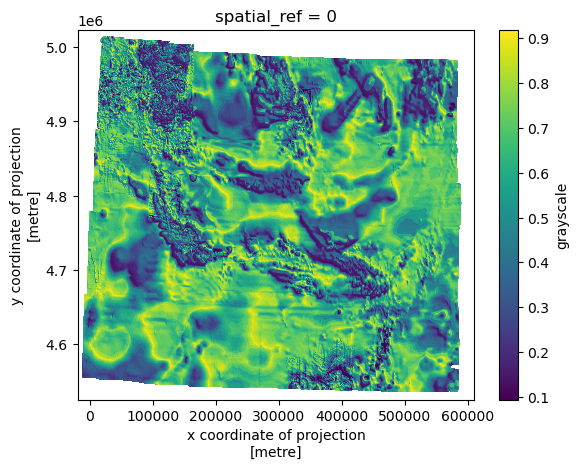

In [14]:
raster1_20m_ds.grayscale.plot()

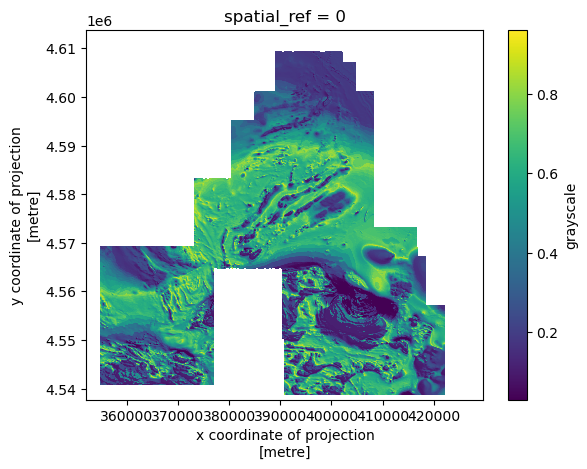

In [15]:
raster2_20m_ds.grayscale.plot()

In [16]:
raster2_20m_ds = raster2_20m_ds.rename({
    'rgb': 'rgb_EarthMRI',
    'grayscale': 'grayscale_EarthMRI',
                       })

### Let's merge em

In [17]:
raster1_20m_ds.to_netcdf('raster1.nc')
raster2_20m_ds.to_netcdf('raster2.nc')

In [2]:
ds1 = xr.open_dataset('raster1.nc')
print(f"ds1 resolution: {ds1.rio.resolution()}")
ds2 = xr.open_dataset('raster2.nc')
print(f"ds2 resolution: {ds2.rio.resolution()}")

ds1 resolution: (25.0, -25.0)
ds2 resolution: (25.0, -25.0)


In [3]:
def align_and_merge_datasets(ds1, ds2, decimal_places=8):
    """
    Align and merge two xarray datasets, putting ds2 onto ds1's dimensions.
    ds2 should be smaller and fit inside ds1's coordinate range.
    
    Parameters:
    -----------
    ds1, ds2 : xarray.Dataset
        The datasets to merge. ds1's dimensions will be preserved.
        ds2 should be smaller and fit within ds1's coordinate range.
    decimal_places : int, optional
        Number of decimal places to round coordinates to
    
    Returns:
    --------
    xarray.Dataset
        Merged dataset with ds1's coordinates
    """
    # Create copies to avoid modifying original datasets
    ds1 = ds1.copy()
    ds2 = ds2.copy()
    
    # Print coordinate ranges before alignment
    print("Coordinate ranges before alignment:")
    print(f"ds1 x: {ds1.x.min().values:.2f} to {ds1.x.max().values:.2f}")
    print(f"ds1 y: {ds1.y.min().values:.2f} to {ds1.y.max().values:.2f}")
    print(f"ds2 x: {ds2.x.min().values:.2f} to {ds2.x.max().values:.2f}")
    print(f"ds2 y: {ds2.y.min().values:.2f} to {ds2.y.max().values:.2f}")
    
    # Verify ds2 fits within ds1
    if (ds2.x.min() < ds1.x.min() or ds2.x.max() > ds1.x.max() or
        ds2.y.min() < ds1.y.min() or ds2.y.max() > ds1.y.max()):
        raise ValueError("ds2 coordinates must fit within ds1 coordinate range")
    
    # Round coordinates
    for coord in ['x', 'y']:
        if coord in ds1.coords and coord in ds2.coords:
            ds1 = ds1.assign_coords({coord: ds1[coord].round(decimal_places)})
            ds2 = ds2.assign_coords({coord: ds2[coord].round(decimal_places)})
    
    # Find the closest indices in ds1 for ds2's boundaries
    x_start_idx = np.abs(ds1.x - ds2.x.min()).argmin()
    x_end_idx = np.abs(ds1.x - ds2.x.max()).argmin()
    y_start_idx = np.abs(ds1.y - ds2.y.min()).argmin()
    y_end_idx = np.abs(ds1.y - ds2.y.max()).argmin()
    
    # Calculate coordinate shifts
    x_shift_start = float(ds1.x[x_start_idx] - ds2.x.min())
    x_shift_end = float(ds1.x[x_end_idx] - ds2.x.max())
    y_shift_start = float(ds1.y[y_start_idx] - ds2.y.min())
    y_shift_end = float(ds1.y[y_end_idx] - ds2.y.max())
    
    print("\nAlignment shifts required:")
    print(f"X shift at start: {x_shift_start:.8f}")
    print(f"X shift at end: {x_shift_end:.8f}")
    print(f"Y shift at start: {y_shift_start:.8f}")
    print(f"Y shift at end: {y_shift_end:.8f}")
    
    # Create a template dataset with ds1's coordinates
    ds2_aligned = ds2.reindex_like(
        ds1,
        method='nearest'
    )
    
    # Merge the datasets
    merged = xr.merge(
        [ds1, ds2_aligned],
        combine_attrs="override"
    )
    
    # Print final dimensions
    print("\nFinal dimensions:")
    print(f"Original ds1: {len(ds1.x)} x points, {len(ds1.y)} y points")
    print(f"Original ds2: {len(ds2.x)} x points, {len(ds2.y)} y points")
    print(f"Merged result: {len(merged.x)} x points, {len(merged.y)} y points")
    
    # Verify dimensions match ds1
    if len(merged.x) != len(ds1.x) or len(merged.y) != len(ds1.y):
        raise ValueError("Merged dataset dimensions do not match ds1 dimensions!")
    
    return merged

In [4]:
merged_ds = align_and_merge_datasets(ds1, ds2, decimal_places=6)

Coordinate ranges before alignment:
ds1 x: -19595.94 to 610479.06
ds1 y: 4525843.11 to 5022768.11
ds2 x: 352158.53 to 429633.53
ds2 y: 4537768.98 to 4613793.98

Alignment shifts required:
X shift at start: -4.47433500
X shift at end: -4.47433500
Y shift at start: -0.87216700
Y shift at end: -0.87216700

Final dimensions:
Original ds1: 25204 x points, 19878 y points
Original ds2: 3100 x points, 3042 y points
Merged result: 25204 x points, 19878 y points


In [5]:
ds1.x

<xarray.DataArray 'x' (x: 25204)> Size: 202kB
array([-19595.944477, -19570.944477, -19545.944477, ..., 610429.055523,
       610454.055523, 610479.055523])
Coordinates:
  * x        (x) float64 202kB -1.96e+04 -1.957e+04 ... 6.105e+05 6.105e+05
Attributes:
    axis:           X
    long_name:      x coordinate of projection
    standard_name:  projection_x_coordinate
    units:          metre

In [6]:
merged_ds.x

<xarray.DataArray 'x' (x: 25204)> Size: 202kB
array([-19595.944477, -19570.944477, -19545.944477, ..., 610429.055523,
       610454.055523, 610479.055523])
Coordinates:
  * x        (x) float64 202kB -1.96e+04 -1.957e+04 ... 6.105e+05 6.105e+05
Attributes:
    axis:           X
    long_name:      x coordinate of projection
    standard_name:  projection_x_coordinate
    units:          metre

In [7]:
merged_ds

<xarray.Dataset> Size: 32GB
Dimensions:             (band: 3, y: 19878, x: 25204)
Coordinates:
  * band                (band) int64 24B 1 2 3
  * x                   (x) float64 202kB -1.96e+04 -1.957e+04 ... 6.105e+05
  * y                   (y) float64 159kB 5.023e+06 5.023e+06 ... 4.526e+06
Data variables:
    spatial_ref         int64 8B 0
    rgb                 (band, y, x) float64 12GB ...
    grayscale           (y, x) float64 4GB ...
    rgb_EarthMRI        (band, y, x) float64 12GB ...
    grayscale_EarthMRI  (y, x) float64 4GB ...

In [ ]:
merged_ds.to_zarr('merged.zarr')

In [21]:
merged_ds = xr.open_dataset('merged.nc')

In [ ]:
# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First subplot - EarthMRI histogram
ax1.hist(merged_ds.grayscale_EarthMRI.values.ravel(), alpha=0.3, label='EarthMRI')
ax1.set_title('EarthMRI Grayscale Distribution')
ax1.set_xlabel('Pixel Value')
ax1.set_ylabel('Frequency')
ax1.legend()

# Second subplot - grayscale histogram
ax2.hist(merged_ds.grayscale.values.ravel(), alpha=0.3, label='Grayscale')
ax2.set_title('Regular Grayscale Distribution')
ax2.set_xlabel('Pixel Value')
ax2.set_ylabel('Frequency')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

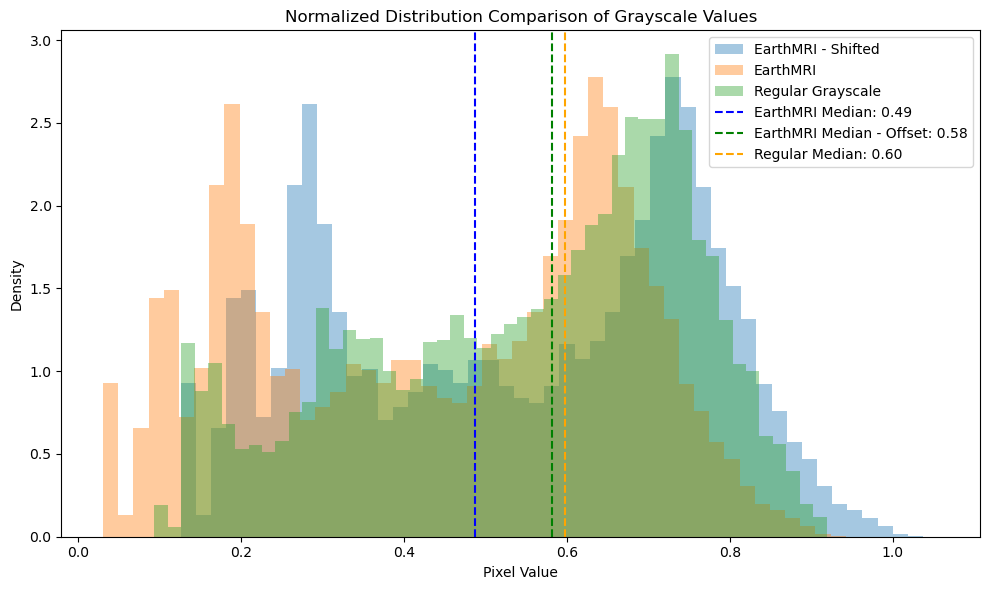

In [23]:
offset = 0.095

# Calculate medians
median_earthmri = np.nanmedian(merged_ds.grayscale_EarthMRI.values.ravel())
median_regular = np.nanmedian(merged_ds.grayscale.values.ravel())

# Create figure
plt.figure(figsize=(10, 6))

# Plot both histograms with density=True for normalization
plt.hist(offset+merged_ds.grayscale_EarthMRI.values.ravel(), density=True, alpha=0.4, label='EarthMRI - Shifted', bins=50)
plt.hist(merged_ds.grayscale_EarthMRI.values.ravel(), density=True, alpha=0.4, label='EarthMRI', bins=50)
plt.hist(merged_ds.grayscale.values.ravel(), density=True, alpha=0.4, label='Regular Grayscale', bins=50)

# Add vertical lines for medians
plt.axvline(x=median_earthmri, color='blue', linestyle='--', label=f'EarthMRI Median: {median_earthmri:.2f}')
plt.axvline(x=median_earthmri+offset, color='green', linestyle='--', label=f'EarthMRI Median - Offset: {offset+median_earthmri:.2f}')
plt.axvline(x=median_regular, color='orange', linestyle='--', label=f'Regular Median: {median_regular:.2f}')

# Add labels and title
plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.title('Normalized Distribution Comparison of Grayscale Values')
plt.legend()

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [24]:
print(merged_ds.grayscale_EarthMRI.dims)

('y', 'x')


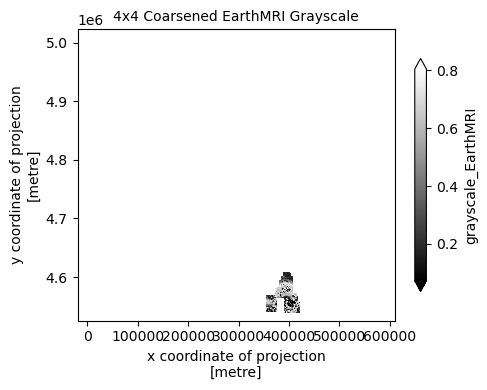

In [25]:
# Create small figure
fig, ax = plt.subplots(figsize=(5, 4))

# Coarsen and plot using 4x4
merged_ds.grayscale_EarthMRI.coarsen(
    y=4,
    x=4,
    boundary='trim'
).mean().plot(
    ax=ax,
    cmap='gray',
    robust=True,
    add_colorbar=True,
    cbar_kwargs={'shrink': 0.8}
)

plt.title('4x4 Coarsened EarthMRI Grayscale', fontsize=10)
plt.tight_layout()
plt.show()

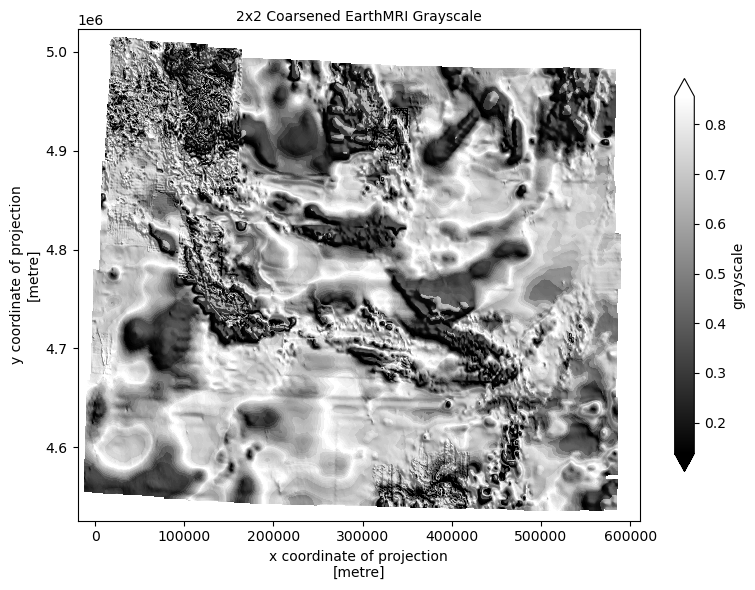

In [26]:
# Create small figure
fig, ax = plt.subplots(figsize=(8, 6))

# Coarsen and plot using 8x8
merged_ds.grayscale.coarsen(
    y=4,
    x=4,
    boundary='trim'
).mean().plot(
    ax=ax,
    cmap='gray',
    robust=True,
    add_colorbar=True,
    cbar_kwargs={'shrink': 0.8}
)

plt.title('2x2 Coarsened EarthMRI Grayscale', fontsize=10)
plt.tight_layout()
plt.show()

In [27]:
array1 = merged_ds['grayscale'].values
array2 = merged_ds['grayscale_EarthMRI'].values

In [28]:
# Print shapes and verification
print(f"Shape of array1: {array1.shape}")
print(f"Shape of array2: {array2.shape}")
print(f"Do shapes match? {array1.shape == array2.shape}")

# Convert boolean mask to 0s and 1s
mask = np.logical_and(~np.isnan(array2), array2 != 0).astype(int)
print(f"Shape of mask: {mask.shape}")

print(f"Unique values in mask: {np.unique(mask)}")  # Should show [0, 1]
print(f"Number of 1s in mask: {np.sum(mask)}")  # Should be same as before: ~6.8 million

print("\nMask Statistics:")
print(f"Number of True values in mask: {np.sum(mask)}")
print(f"Percentage of True values: {(np.sum(mask)/mask.size)*100:.2f}%")
print(f"Mask max value: {np.nanmax(mask)}")
print(f"Mask min value: {np.nanmin(mask)}")

# Check actual data in array2
print("\nArray2 Data Statistics:")
print(f"Number of non-NaN and non-zero values: {np.sum(~np.isnan(array2) & (array2 != 0))}")
print(f"Percentage of non-NaN and non-zero values: {(np.sum(~np.isnan(array2) & (array2 != 0))/array2.size)*100:.2f}%")
print(f"Mask max value: {np.nanmax(array2)}")
print(f"Mask min value: {np.nanmin(array2)}")

Shape of array1: (22920, 28304)
Shape of array2: (22920, 28304)
Do shapes match? True
Shape of mask: (22920, 28304)
Unique values in mask: [0 1]
Number of 1s in mask: 4396880

Mask Statistics:
Number of True values in mask: 4396880
Percentage of True values: 0.68%
Mask max value: 1
Mask min value: 0

Array2 Data Statistics:
Number of non-NaN and non-zero values: 4396880
Percentage of non-NaN and non-zero values: 0.68%
Mask max value: 0.9609700980392495
Mask min value: 0.030872230392150115


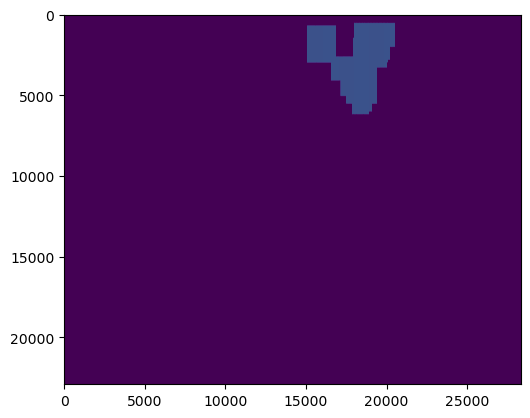

In [29]:
plt.imshow(mask)

In [30]:
merged_ds

<xarray.Dataset> Size: 42GB
Dimensions:             (band: 3, x: 28304, y: 22920)
Coordinates:
  * band                (band) int64 24B 1 2 3
  * x                   (x) float64 226kB -1.96e+04 -1.957e+04 ... 6.105e+05
  * y                   (y) float64 183kB 4.526e+06 4.526e+06 ... 5.023e+06
Data variables:
    spatial_ref         int64 8B ...
    rgb                 (band, y, x) float64 16GB ...
    grayscale           (y, x) float64 5GB nan nan nan nan ... nan nan nan nan
    rgb_EarthMRI        (band, y, x) float64 16GB ...
    grayscale_EarthMRI  (y, x) float64 5GB nan nan nan nan ... nan nan nan nan

In [31]:
merged_ds['mask'] = xr.DataArray(
    data=mask,
    dims=['y', 'x'])

In [32]:
unique_values, counts = np.unique(merged_ds.mask.values, return_counts=True)
unique_values, counts

(array([0, 1]), array([644330800,   4396880]))

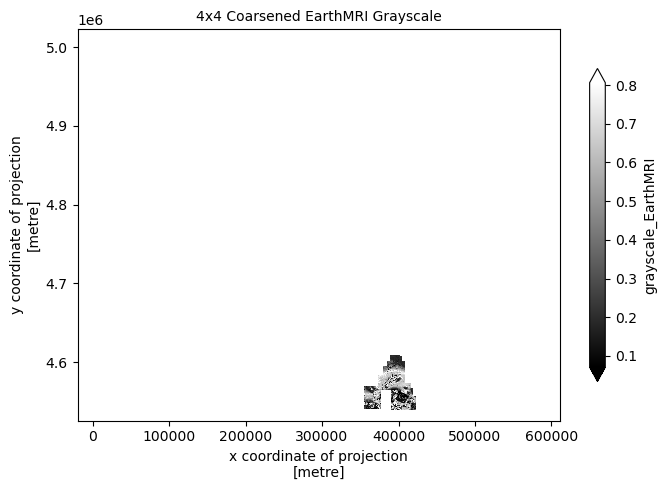

In [49]:
# Create small figure
fig, ax = plt.subplots(figsize=(7, 5))

# Coarsen and plot using 4x4
merged_ds.grayscale_EarthMRI.coarsen(
    y=2,
    x=2,
    boundary='trim'
).mean().plot(
    ax=ax,
    cmap='gray',
    robust=True,
    add_colorbar=True,
    cbar_kwargs={'shrink': 0.8}
)

plt.title('4x4 Coarsened EarthMRI Grayscale', fontsize=10)
plt.tight_layout()
plt.show()

In [34]:
# Method 1: Using stack
array_3d = np.stack([merged_ds.mask.values, 
                     merged_ds.grayscale.values, 
                     merged_ds.grayscale_EarthMRI.values], axis=0)

array_3d.shape

(3, 22920, 28304)

In [37]:
unique_values, counts = np.unique(array_3d[0], return_counts=True)
unique_values, counts

(array([0., 1.]), array([644330800,   4396880]))

In [51]:
print(f"NaN values - state: {np.sum(np.isnan(array_3d[1]))}")
print(f"Non-NaN values - state: {np.sum(~np.isnan(array_3d[1]))}")

print(f"NaN values: {np.sum(np.isnan(array_3d[2]))}")
print(f"Non-NaN values: {np.sum(~np.isnan(array_3d[2]))}")

NaN values - state: 227204681
Non-NaN values - state: 421522999
NaN values: 644330800
Non-NaN values: 4396880


In [48]:
# Check channel 3 for NaN distribution
ch3 = array_3d[2]
print(f"Total elements in channel 3: {ch3.size}")
print(f"Number of NaN values: {np.sum(np.isnan(ch3))}")
print(f"Percentage of NaN values: {(np.sum(np.isnan(ch3)) / ch3.size) * 100:.2f}%")

# Let's check a small region
small_size = 16
i, j = 0, 0  # start position
sample = ch3[i:i+small_size, j:j+small_size]
print(f"\nSample {small_size}x{small_size} region NaN count: {np.sum(np.isnan(sample))}")
print(f"Sample contains all NaN: {np.all(np.isnan(sample))}")
print(f"Sample contains any NaN: {np.any(np.isnan(sample))}")

Total elements in channel 3: 648727680
Number of NaN values: 644330800
Percentage of NaN values: 99.32%

Sample 16x16 region NaN count: 256
Sample contains all NaN: True
Sample contains any NaN: True


In [52]:
def sample_squares(array3d, num_squares, square_size, layer1, layer2):
    """
    Sample random squares from two specific layers of a 3D array.
    
    Parameters:
    -----------
    array3d : numpy.ndarray
        Input 3D array with shape (depth, height, width)
    num_squares : int
        Number of squares to sample
    square_size : int
        Size of each square (square_size x square_size)
    layer1 : int
        First layer to sample from
    layer2 : int
        Second layer to sample from
        
    Returns:
    --------
    tuple
        Two 3D numpy arrays, each with shape (num_squares, square_size, square_size)
    """
    
    height, width = array3d.shape[1:]
    
    # Validate inputs
    if square_size > min(height, width):
        raise ValueError("Square size cannot be larger than array dimensions")
    
    # Calculate valid ranges for random sampling
    max_y = height - square_size + 1
    max_x = width - square_size + 1
    
    # Initialize output arrays
    samples1 = np.zeros((num_squares, square_size, square_size))
    samples2 = np.zeros((num_squares, square_size, square_size))
    
    # Sample random squares
    for i in range(num_squares):
        y_start = np.random.randint(0, max_y)
        x_start = np.random.randint(0, max_x)
        
        samples1[i] = array3d[layer1,
                             y_start:y_start + square_size,
                             x_start:x_start + square_size]
        samples2[i] = array3d[layer2,
                             y_start:y_start + square_size,
                             x_start:x_start + square_size]
            
    return samples1, samples2

In [64]:
state_samples, earth_mri_samples = sample_squares(array_3d, 
                                      num_squares=100,  # or however many squares you want
                                      square_size=64,  # or whatever size you want
                                      layer1 = 1,
                                      layer2 = 2)   # specifically selecting layers 2 and 3

In [65]:
state_samples.shape

(100, 64, 64)

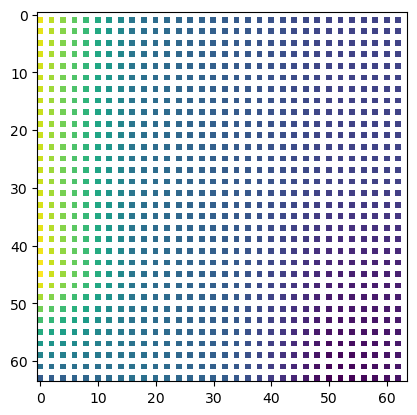

In [75]:
plt.imshow(state_samples[94])


In [76]:
non_nan_indices = np.where(~np.isnan(earth_mri_samples).all(axis=(1,2)))[0]
non_nan_indices

array([ 8, 70, 94])

In [74]:
earth_mri_samples[70]

array([[       nan, 0.67075613,        nan, ..., 0.39700071,        nan,
        0.40091402],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 0.65287885,        nan, ..., 0.40505569,        nan,
        0.40879365],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 0.42711512,        nan, ..., 0.44492549,        nan,
        0.43738025],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])